<a href="https://colab.research.google.com/github/PapaDevil5/quality_manufacture/blob/main/quality_manufacture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/d-t-n/quality-inspection-ai-cv-deep-learning/

Cloning into 'quality-inspection-ai-cv-deep-learning'...
remote: Enumerating objects: 8700, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 8700 (delta 56), reused 66 (delta 26), pack-reused 8600 (from 1)
Receiving objects: 100% (8700/8700), 100.28 MiB | 16.42 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Updating files: 100% (7355/7355), done.


In [2]:
%cd quality-inspection-ai-cv-deep-learning

/content/quality-inspection-ai-cv-deep-learning


In [3]:
!kaggle datasets download -d ravirajsinh45/real-life-industrial-dataset-of-casting-product

Dataset URL: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 97% 97.0M/100M [00:05<00:00, 23.2MB/s]
100% 100M/100M [00:05<00:00, 17.5MB/s] 


In [4]:
!unzip real-life-industrial-dataset-of-casting-product.zip -d casting_data/

Streaming output truncated to the last 5000 lines.
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5259.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_526.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5260.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5262.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5265.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_527.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5270.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5272.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_5274.jpeg  
  inflating: casting_data/casting_data/casting_data/train/def_front/cast_def_0_528.jpeg  
  inflating: casting_data/casting_data/cas

In [5]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.models import Sequential
from sklearn import metrics

In [6]:
# defining dir variables
root_dir = 'archive/casting_data/casting_data/'
train_defective = root_dir + 'train/def_front/'
train_ok = root_dir + 'train/ok_front/'

test_defective = root_dir + 'test/def_front/'
test_ok = root_dir + 'test/ok_front/'

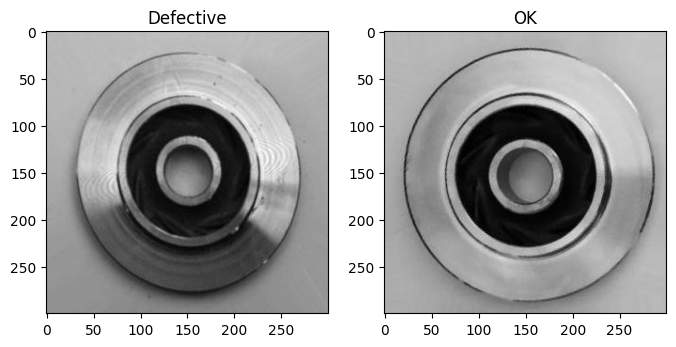

In [7]:
# Ploting images

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(plt.imread(train_defective+os.listdir(train_defective)[0]))
axes[1].imshow(plt.imread(train_ok+os.listdir(train_ok)[0]))
axes[0].set_title('Defective')
axes[1].set_title('OK')
plt.show()

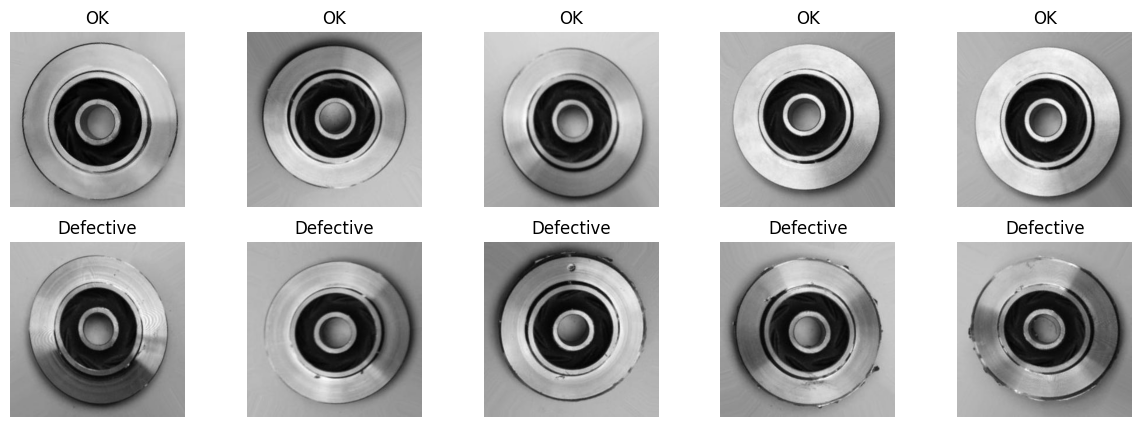

In [8]:
num_images = 5

fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(15,5))

# ok images
for i, filename in enumerate(os.listdir(train_ok)[:num_images]):
    img = plt.imread(train_ok + filename)
    axs[0,i].imshow(img)
    axs[0,i].set_title('OK')
    axs[0,i].axis('off')

# defective images
for i, filename in enumerate(os.listdir(train_defective)[:num_images]):
    img = plt.imread(train_defective + filename)
    axs[1,i].imshow(img)
    axs[1,i].set_title('Defective')
    axs[1,i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.2)

# show the plot
plt.show()

# EDA

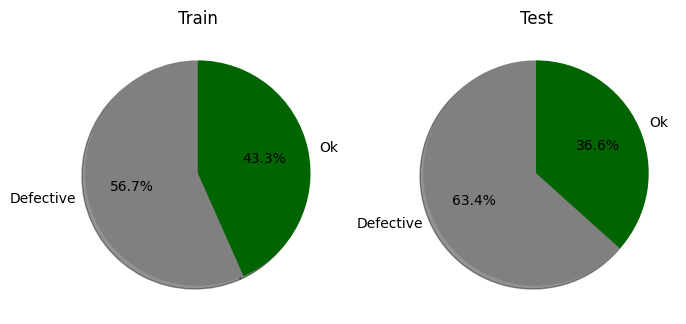

 Defective Training Images 	: 3758
 Ok Training Images 		: 2875

 Defective Testing Images 	: 453
 Ok Testing Images 		: 262


In [9]:
x_train = np.array([len(os.listdir(train_defective)),len(os.listdir(train_ok))])
x_test = np.array([len(os.listdir(test_defective)),len(os.listdir(test_ok))])
label = ['Defective','Ok']
colors = ['grey', 'darkgreen']

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90, colors=colors)
axes[0].set_title('Train')
axes[1].set_title('Test')
plt.show()

print(' Defective Training Images \t: ' + str(len(os.listdir(train_defective))))
print(' Ok Training Images \t\t: ' + str(len(os.listdir(train_ok))))
print()
print(' Defective Testing Images \t: ' + str(len(os.listdir(test_defective))))
print(' Ok Testing Images \t\t: ' + str(len(os.listdir(test_ok))))

In [10]:

# Using IDG to load images from directory
train_idg = ImageDataGenerator(rescale=1./255, validation_split=0.3) # 30 percent validation split for taining
test_idg = ImageDataGenerator(rescale=1./255)

# Specify parameters/arguments for data generation
img_size = (300, 300)
batch_size = 64

arg_train = {'target_size': img_size,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_size}
arg_test = {'target_size': img_size,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_size,
            'shuffle': False}

train = train_idg.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
valid = train_idg.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
test  = test_idg.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


## Xception

In [11]:
from tensorflow.keras.applications import Xception
xcept = Xception(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in xcept.layers:
    layer.trainable = False

cnn = keras.Sequential([
    xcept,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnn.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 204800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      52,429,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,290,793 (279.58 MB)

 Trainable params: 52,429,313 (200.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [13]:
history = cnn.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6786 - loss: 9.0077 - val_accuracy: 0.9477 - val_loss: 0.5530
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9405 - loss: 0.4443 - val_accuracy: 0.9844 - val_loss: 0.1470
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9890 - loss: 0.0764 - val_accuracy: 0.9829 - val_loss: 0.0707
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9781 - loss: 0.0957 - val_accuracy: 0.9844 - val_loss: 0.0523
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9783 - loss: 0.0731 - val_accuracy: 0.9869 - val_loss: 0.0870
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9856 - loss: 0.0777 - val_accuracy: 0.9889 - val_loss: 0.0353
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9866 - loss: 0.0477 - val_accuracy: 0.9884 - val_loss: 0.0357
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9934 - loss: 0.0202 - val_accuracy: 0.9935 - val_loss:

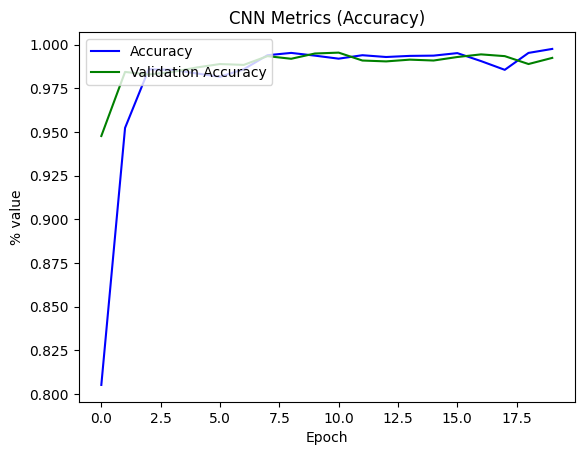

In [14]:
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

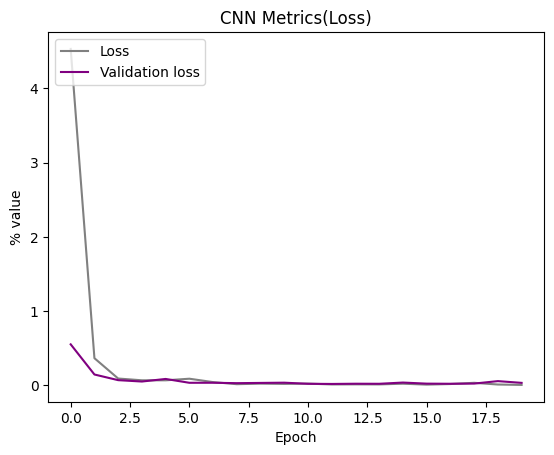

In [15]:
plt.plot(history.history['loss'], color='grey', label='Loss')
plt.plot(history.history['val_loss'], color='purple', label='Validation loss')
plt.title('CNN Metrics(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [16]:
y_pred = cnn.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


In [17]:
y_actual = test.classes[test.index_array]

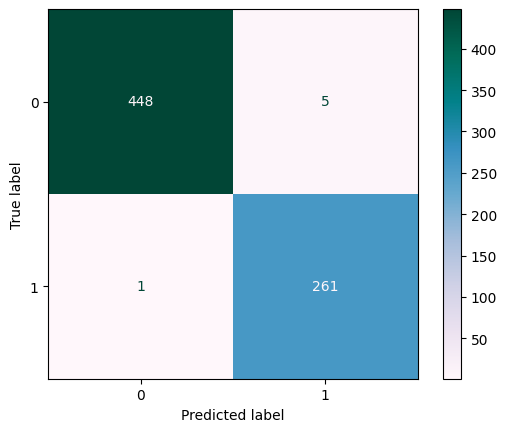

In [18]:
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='PuBuGn')
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9978    0.9890    0.9933       453
           1     0.9812    0.9962    0.9886       262

    accuracy                         0.9916       715
   macro avg     0.9895    0.9926    0.9910       715
weighted avg     0.9917    0.9916    0.9916       715



In [22]:
import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime
from tensorflow.keras.applications import InceptionResNetV2
IncResNV2 = InceptionResNetV2(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

for layer in IncResNV2.layers:
    layer.trainable = False

cnn = keras.Sequential([
    IncResNV2,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnn.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 8, 8, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 98304)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      25,166,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,503,073 (303.28 MB)

 Trainable params: 25,166,337 (96.00 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [23]:
history = cnn.fit(
    train,
    steps_per_epoch=50,
    validation_data=valid,
    epochs=20
    )

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8072 - loss: 6.2105 - val_accuracy: 0.9769 - val_loss: 0.1442
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 585ms/step - accuracy: 0.9879 - loss: 0.0503 - val_accuracy: 0.9935 - val_loss: 0.0331
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 869ms/step - accuracy: 0.9884 - loss: 0.0352 - val_accuracy: 0.9925 - val_loss: 0.0259
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 572ms/step - accuracy: 0.9884 - loss: 0.0393 - val_accuracy: 0.9894 - val_loss: 0.0397
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 861ms/step - accuracy: 0.9972 - loss: 0.0106 - val_accuracy: 0.9915 - val_loss: 0.0360
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 575ms/step - accuracy: 0.9909 - loss: 0.0292 - val_accuracy: 0.9935 - val_loss: 0.0255
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 871ms/step - accuracy: 0.9946 - loss: 0.0193 - val_accuracy: 0.9849 - val_loss: 0.0391
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 572ms/step - accuracy: 0.9919 - loss: 0.0193 - val_accura

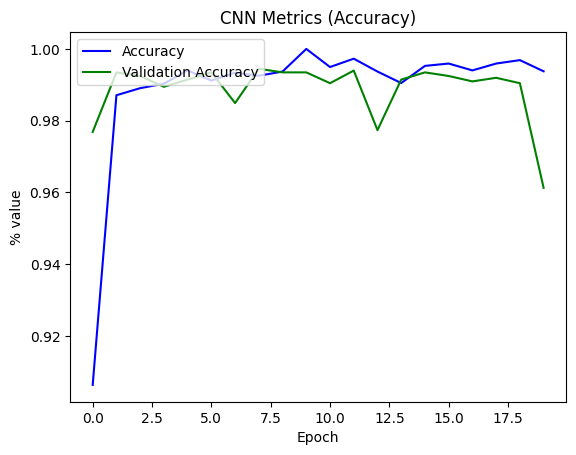

In [24]:
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('CNN Metrics (Accuracy)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

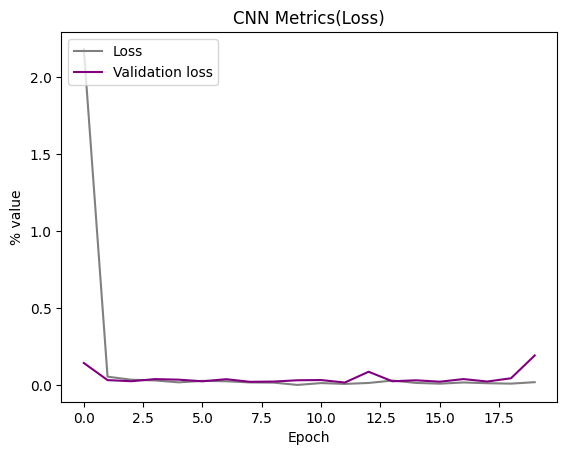

In [25]:
plt.plot(history.history['loss'], color='grey', label='Loss')
plt.plot(history.history['val_loss'], color='purple', label='Validation loss')
plt.title('CNN Metrics(Loss)')
plt.ylabel('% value')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

In [26]:
y_pred = cnn.predict(test)
y_pred = (y_pred >= 0.5).reshape(-1,)

12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step


In [27]:
y_actual = test.classes[test.index_array]

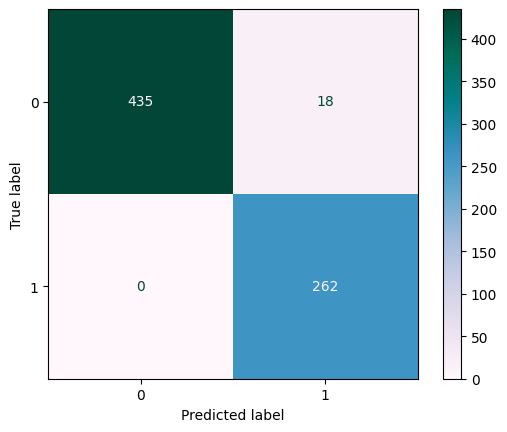

In [28]:
cm = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='PuBuGn')
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9603    0.9797       453
           1     0.9357    1.0000    0.9668       262

    accuracy                         0.9748       715
   macro avg     0.9679    0.9801    0.9733       715
weighted avg     0.9764    0.9748    0.9750       715



## MobileNet

In [30]:
train_idgm = ImageDataGenerator(rescale=1./255, validation_split=0.3)
test_idgm = ImageDataGenerator(rescale=1./255)

img_sizem = (300, 300)
batch_sizem = 64

arg_trainm = {'target_size': img_sizem,
             'color_mode': 'rgb',
             'class_mode': 'binary',
             'batch_size': batch_sizem}
arg_testm = {'target_size': img_sizem,
            'color_mode': 'rgb',
            'class_mode': 'binary',
            'batch_size': batch_sizem,
            'shuffle': False}

trainm = train_idgm.flow_from_directory(directory=root_dir+'train/', subset='training', **arg_train)
validm = train_idgm.flow_from_directory(directory=root_dir+'train/', subset='validation', **arg_train)
testm  = test_idgm.flow_from_directory(directory=root_dir+'test/', **arg_test)

Found 4644 images belonging to 2 classes.
Found 1989 images belonging to 2 classes.
Found 715 images belonging to 2 classes.


In [31]:
from tensorflow.keras.applications import MobileNet
mobilenet = MobileNet(input_shape = (300, 300, 3), include_top = False, weights = 'imagenet')

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [32]:
import os
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models
import datetime

for layer in mobilenet.layers:
    layer.trainable = False

cnnm = keras.Sequential([
    mobilenet,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=1, activation="sigmoid"),
])

cnnm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


cnnm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 9, 9, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      21,233,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,463,041 (93.32 MB)

 Trainable params: 21,234,177 (81.00 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [33]:
historym = cnnm.fit(
    train,
    validation_data=valid,
    epochs=20,
    steps_per_epoch=20,
    verbose = 1
    )

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 987ms/step - accuracy: 0.5741 - loss: 21.1694 - val_accuracy: 0.6038 - val_loss: 1.3952
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 483ms/step - accuracy: 0.7771 - loss: 0.9573 - val_accuracy: 0.9407 - val_loss: 0.1343
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 488ms/step - accuracy: 0.9561 - loss: 0.1529 - val_accuracy: 0.9814 - val_loss: 0.0543
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - accuracy: 0.9522 - loss: 0.1112 - val_accuracy: 0.9910 - val_loss: 0.0321
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 487ms/step - accuracy: 0.9785 - loss: 0.0618 - val_accuracy: 0.9940 - val_loss: 0.0297
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 706ms/step - accuracy: 0.9826 - loss: 0.0619 - val_accuracy: 0.9910 - val_loss: 0.0278
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - accuracy: 0.9890 - loss: 0.0512 - val_accuracy: 0.9910 - val_loss: 0.0267
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.9940 - loss: 0.0437 - val_accuracy

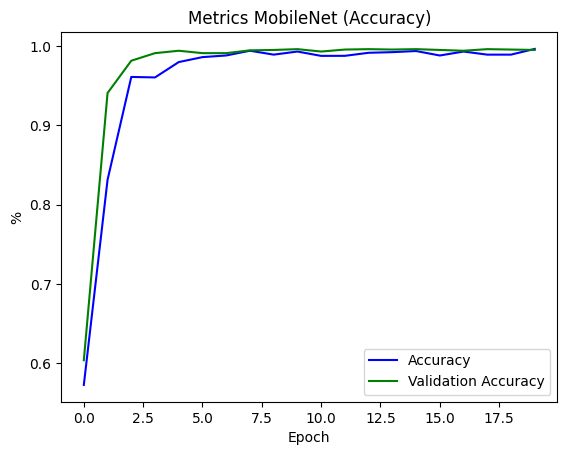

In [34]:
plt.plot(historym.history['accuracy'], color='blue', label='Accuracy')
plt.plot(historym.history['val_accuracy'], color='green', label='Validation Accuracy')
plt.title('Metrics MobileNet (Accuracy)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

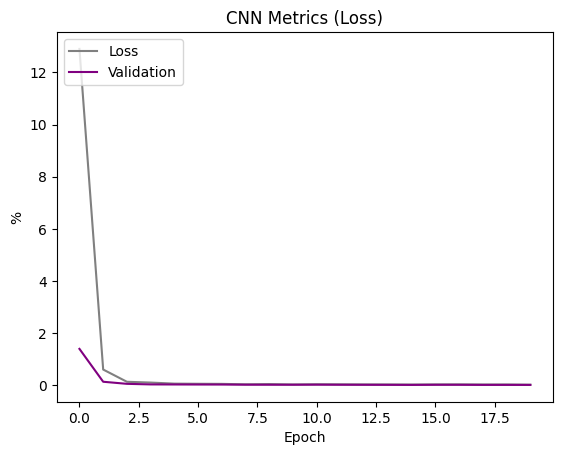

In [35]:
plt.plot(historym.history['loss'], color='grey', label='Loss')
plt.plot(historym.history['val_loss'], color='purple', label='Validation')
plt.title('CNN Metrics (Loss)')
plt.ylabel('%')
plt.xlabel('Epoch')
plt.legend(loc="upper left")
plt.show()

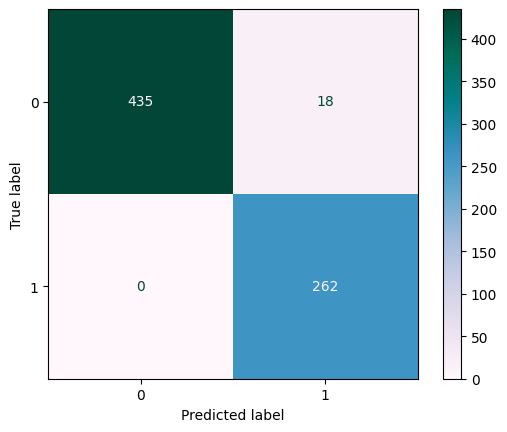

In [36]:
cnn = metrics.confusion_matrix(y_actual, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnn)
disp.plot(cmap='PuBuGn')
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_pred, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9603    0.9797       453
           1     0.9357    1.0000    0.9668       262

    accuracy                         0.9748       715
   macro avg     0.9679    0.9801    0.9733       715
weighted avg     0.9764    0.9748    0.9750       715



# ROC Curve

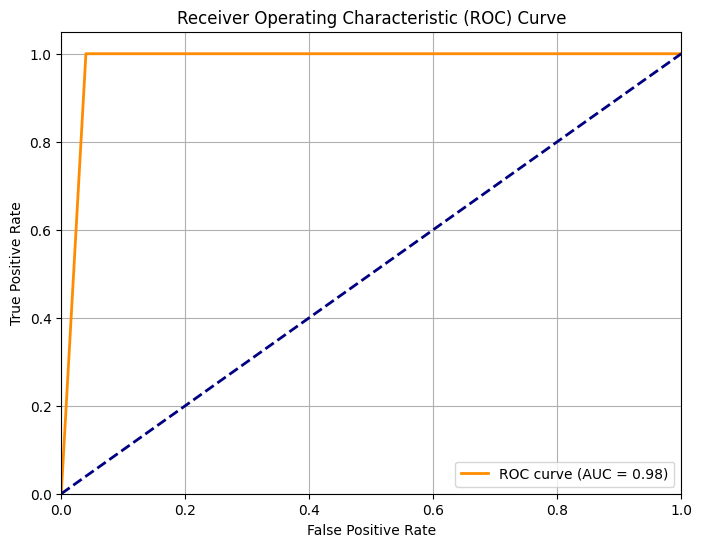

In [39]:
from sklearn.metrics import roc_curve, auc # Importing the necessary functions

fpr, tpr, _ = roc_curve(y_actual, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()